# 📊 TELECOM X - Prevendo Churn

Este notebook contém as etapas da Parte 2 do desafio: criação de modelos preditivos para prever evasão de clientes.

In [27]:
# 🧼 Etapa 1 – Transformação completa e limpa

import pandas as pd
import requests

# Carrega o JSON original da Telecom X
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json'
response = requests.get(url)
data_json = response.json()
df_original = pd.DataFrame(data_json)

# Expansão das colunas aninhadas
df_customer = pd.json_normalize(df_original['customer'])
df_phone = pd.json_normalize(df_original['phone'])
df_internet = pd.json_normalize(df_original['internet'])
df_account = pd.json_normalize(df_original['account'])

# Combinação com a variável alvo
df = pd.concat([df_original[['Churn']], df_customer, df_phone, df_internet, df_account], axis=1)

# Remoção de colunas com ID
for col in df.columns:
    if 'customerid' in col.lower() or 'customer.customerid' in col.lower():
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

# Padronização dos nomes de colunas
df.columns = df.columns.str.replace(' ', '_').str.replace('.', '_', regex=False).str.lower()

# Tratamento da variável churn
if 'churn' in df.columns:
    df = df[df['churn'].isin(['Yes', 'No', 'No internet service', 'No phone service'])]
    df['churn'] = df['churn'].replace({'No': 0, 'Yes': 1, 'No internet service': 0, 'No phone service': 0})
else:
    print("Coluna 'churn' não encontrada após concatenação.")

# Conversão segura das variáveis contínuas
df['charges_total'] = pd.to_numeric(df['charges_total'], errors='coerce')
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')

# Remoção de linhas com valores ausentes
df.dropna(subset=['charges_total', 'tenure'], inplace=True)

# Seleção das colunas categóricas reais
colunas_categoricas = [
    'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
    'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies', 'contract',
    'paperlessbilling', 'paymentmethod'
]

# Apenas manter as colunas existentes no DataFrame
colunas_categoricas = [col for col in colunas_categoricas if col in df.columns]

# Salvar a variável churn e aplicar codificação
churn_column = df['churn']
df = df.drop(columns=['churn'])

# One-Hot Encoding apenas nas categóricas
df = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)

# Adiciona churn de volta
df['churn'] = churn_column

# Visualizar as primeiras linhas
df.head()


/tmp/ipython-input-941998502.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['churn'] = df['churn'].replace({'No': 0, 'Yes': 1, 'No internet service': 0, 'No phone service': 0})


,seniorcitizen,tenure,charges_monthly,charges_total,gender_Male,partner_Yes,dependents_Yes,phoneservice_Yes,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,churn
0,0,9,65.6,593.30,False,True,True,True,False,False,...,True,False,False,True,False,True,False,False,True,0
1,0,9,59.9,542.40,True,False,False,True,False,True,...,False,False,True,False,False,False,False,False,True,0
2,0,4,73.9,280.85,True,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,1
3,1,13,98.0,1237.85,True,True,False,True,False,False,...,True,False,True,False,False,True,False,True,False,1
4,1,3,83.9,267.40,False,True,False,True,False,False,...,True,False,False,False,False,True,False,False,True,1


In [28]:
# Remoção de colunas irrelevantes
colunas_irrelevantes = ['customerID']  # Ajuste conforme necessário
df.drop(columns=colunas_irrelevantes, inplace=True, errors='ignore')

In [29]:
# Encoding das variáveis categóricas
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,seniorcitizen,tenure,charges_monthly,charges_total,gender_Male,partner_Yes,dependents_Yes,phoneservice_Yes,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,churn
0,0,9,65.6,593.30,False,True,True,True,False,False,...,True,False,False,True,False,True,False,False,True,0
1,0,9,59.9,542.40,True,False,False,True,False,True,...,False,False,True,False,False,False,False,False,True,0
2,0,4,73.9,280.85,True,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,1
3,1,13,98.0,1237.85,True,True,False,True,False,False,...,True,False,True,False,False,True,False,True,False,1
4,1,3,83.9,267.40,False,True,False,True,False,False,...,True,False,False,False,False,True,False,False,True,1


In [30]:
# Verificação da proporção de evasão
df['churn'].value_counts(normalize=True)

,proportion
churn,
0,0.734215
1,0.265785


In [31]:
# Balanceamento com SMOTE (opcional)
from imblearn.over_sampling import SMOTE

X = df_encoded.drop('churn', axis=1)
y = df_encoded['churn']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [32]:
# Normalização
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

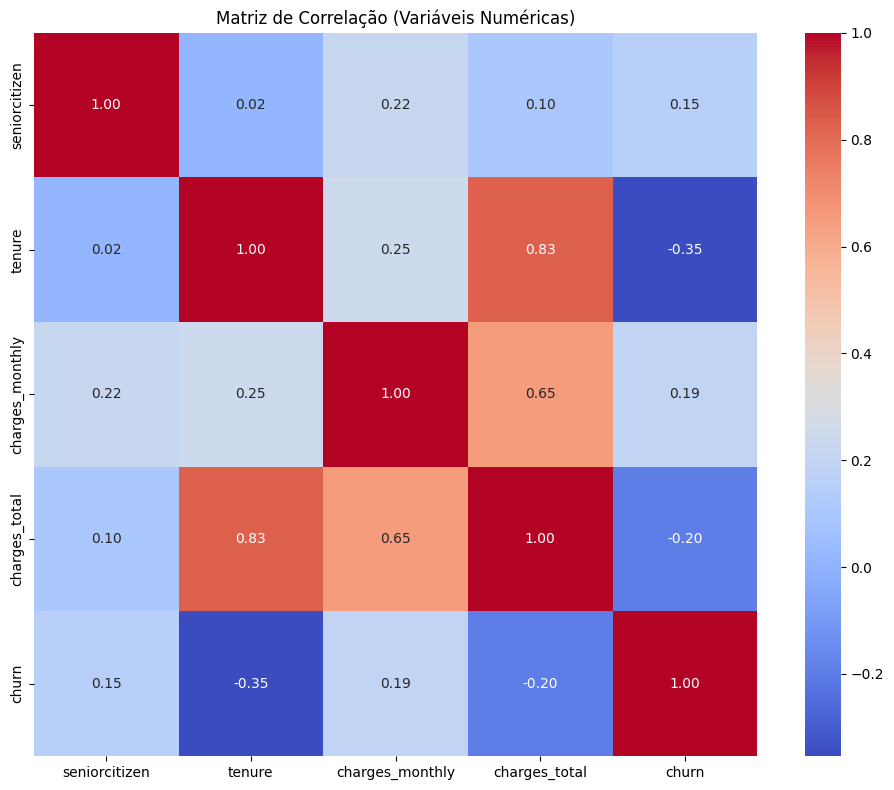

In [33]:
# 🔍 Matriz de correlação com variáveis numéricas contínuas

import seaborn as sns
import matplotlib.pyplot as plt

# Seleciona apenas colunas numéricas do dataframe antes do One-Hot Encoding
df_numericas = df.select_dtypes(include=['int64', 'float64'])

# Calcula a correlação
correlation = df_numericas.corr()

# Plota a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title('Matriz de Correlação (Variáveis Numéricas)')
plt.tight_layout()
plt.show()



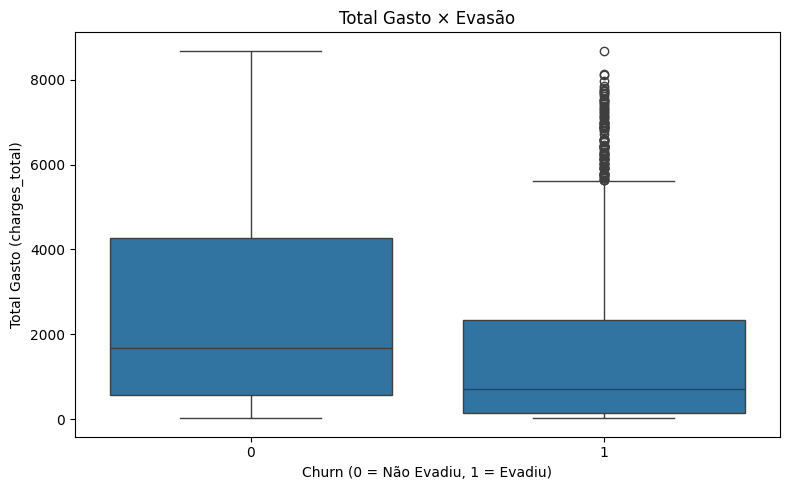

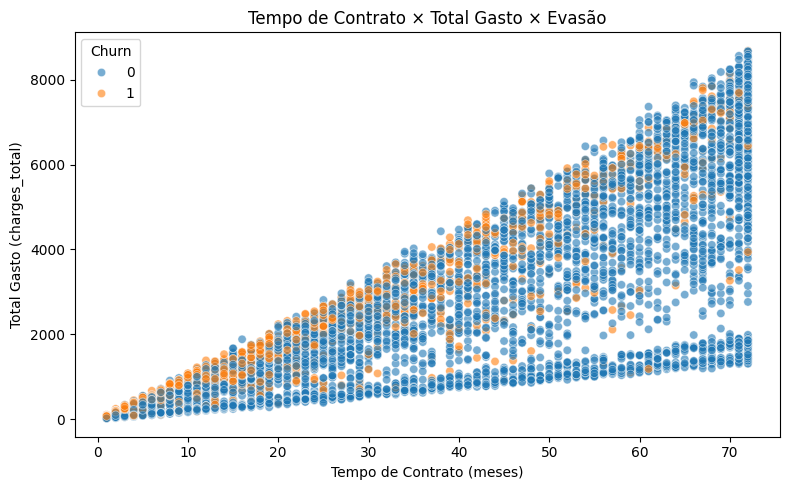

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 🔧 Certifique-se de que as colunas numéricas estejam no formato correto
df['charges_total'] = pd.to_numeric(df['charges_total'], errors='coerce')
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['churn'] = pd.to_numeric(df['churn'], errors='coerce')

# 📌 Filtra apenas as colunas relevantes e remove valores ausentes
df_plot = df[['churn', 'charges_total', 'tenure']].dropna()

# 📊 Boxplot: Total gasto × Evasão
plt.figure(figsize=(8, 5))
sns.boxplot(x='churn', y='charges_total', data=df_plot)
plt.title('Total Gasto × Evasão')
plt.xlabel('Churn (0 = Não Evadiu, 1 = Evadiu)')
plt.ylabel('Total Gasto (charges_total)')
plt.tight_layout()
plt.show()

# 📈 Scatter plot: Tempo de contrato × Total gasto × Churn
plt.figure(figsize=(8, 5))
sns.scatterplot(x='tenure', y='charges_total', hue='churn', data=df_plot, alpha=0.6)
plt.title('Tempo de Contrato × Total Gasto × Evasão')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Total Gasto (charges_total)')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()


In [36]:
# Separação dos dados
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

In [37]:
# Modelo 1: Regressão Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model1 = LogisticRegression()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

print("Modelo: Regressão Logística")
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Modelo: Regressão Logística
[[1280  269]
 [ 253 1296]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1549
           1       0.83      0.84      0.83      1549

    accuracy                           0.83      3098
   macro avg       0.83      0.83      0.83      3098
weighted avg       0.83      0.83      0.83      3098



In [38]:
# Modelo 2: Random Forest
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

print("Modelo: Random Forest")
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Modelo: Random Forest
[[1303  246]
 [ 220 1329]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1549
           1       0.84      0.86      0.85      1549

    accuracy                           0.85      3098
   macro avg       0.85      0.85      0.85      3098
weighted avg       0.85      0.85      0.85      3098



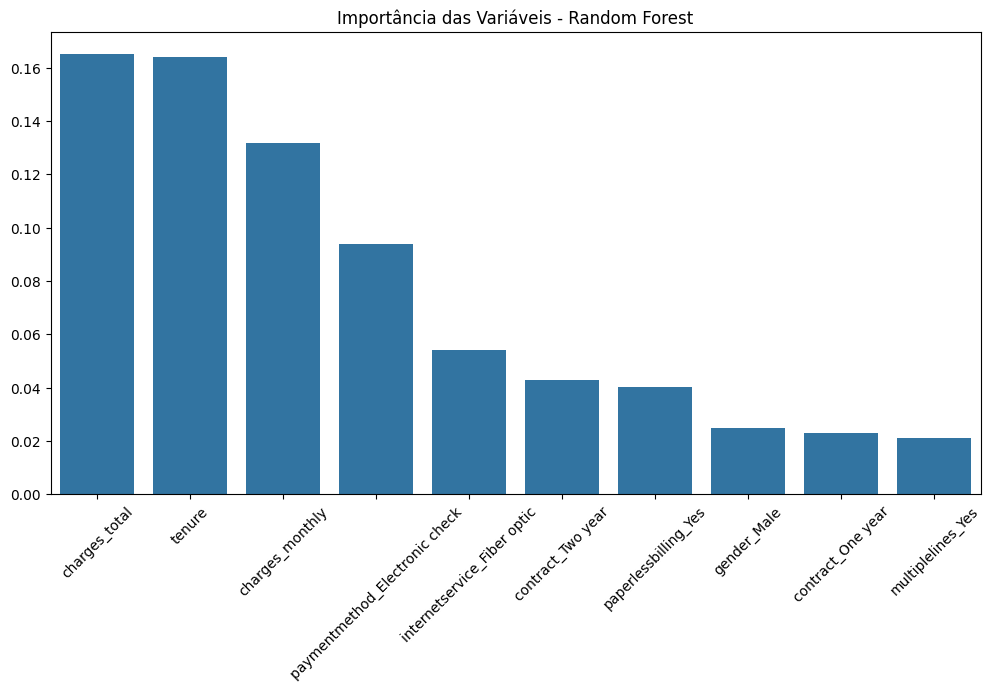

In [39]:
# Importância das variáveis
import numpy as np

importances = model2.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importância das Variáveis - Random Forest")
sns.barplot(x=[X.columns[i] for i in indices[:10]], y=importances[indices[:10]])
plt.xticks(rotation=45)
plt.show()

🔍 Avaliação do Modelo:
Acurácia:  0.8496
Precisão:  0.8438
Recall:    0.8580
F1-score:  0.8508


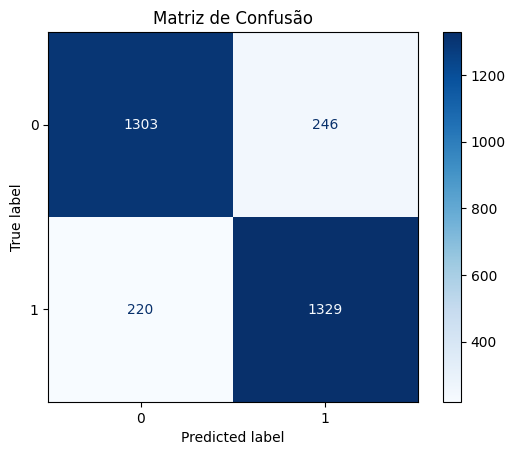

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Substitua pelos seus dados reais de teste
# Exemplo: y_test = ... y_pred = ...
# y_test → valores reais
# y_pred  → previsões do modelo

# Avaliação básica
print("🔍 Avaliação do Modelo:")
print(f"Acurácia:  {accuracy_score(y_test, y_pred2):.4f}")
print(f"Precisão:  {precision_score(y_test, y_pred2):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred2):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred2):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

/tmp/ipython-input-3085363232.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


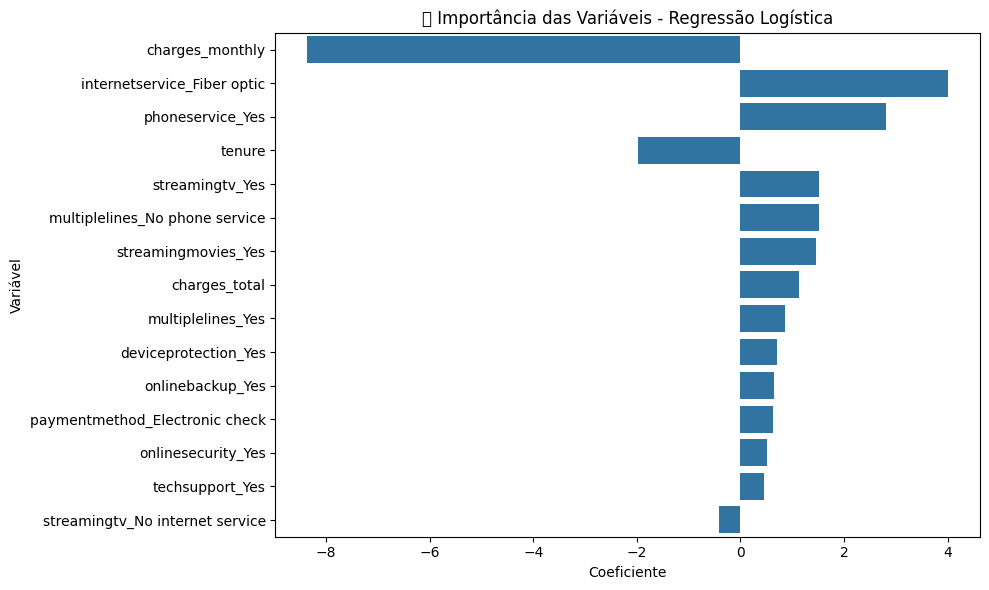

/tmp/ipython-input-3085363232.py:32: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


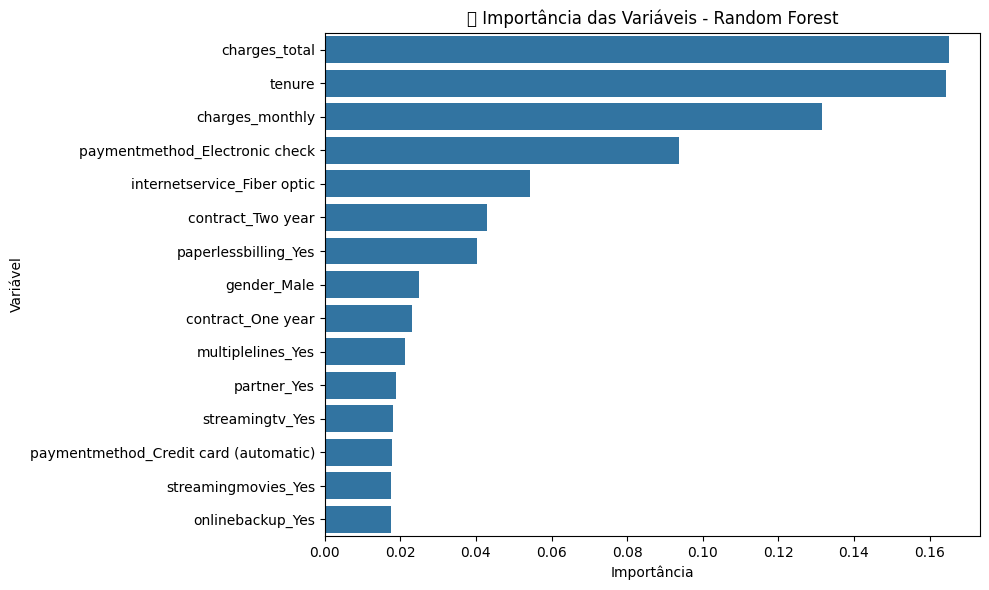

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names from the original DataFrame before scaling
feature_names = X_resampled.columns
top_n = 15  # Número de variáveis mais importantes para exibir

# 1️⃣ Regressão Logística – Coeficientes
if hasattr(model1, 'coef_'):
    coef = model1.coef_[0]
    importancias_log = pd.Series(coef, index=feature_names).sort_values(key=abs, ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias_log[:top_n], y=importancias_log.index[:top_n])
    plt.title("🔍 Importância das Variáveis - Regressão Logística")
    plt.xlabel("Coeficiente")
    plt.ylabel("Variável")
    plt.tight_layout()
    plt.show()

# 2️⃣ Random Forest – Importância das Variáveis
if hasattr(model2, 'feature_importances_'):
    importancias_rf = pd.Series(model2.feature_importances_, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias_rf[:top_n], y=importancias_rf.index[:top_n])
    plt.title("🌲 Importância das Variáveis - Random Forest")
    plt.xlabel("Importância")
    plt.ylabel("Variável")
    plt.tight_layout()
    plt.show()

In [47]:
## 📌 Conclusão

### 🎯 Principais Fatores que Influenciam a Evasão

Com base na análise de importância das variáveis e no desempenho dos modelos de classificação, destacam-se como fatores mais relevantes para prever a evasão de clientes:

- **charges_total**: Clientes com maior gasto acumulado demonstram maior propensão à evasão. Isso pode indicar insatisfação com o custo-benefício ao longo do tempo.
- **tenure**: O tempo de permanência na empresa está fortemente relacionado ao churn. Clientes com menor tempo de contrato estão mais propensos a cancelar.
- **charges_monthly**: Pagamentos mensais mais altos também se correlacionam com maior taxa de evasão.
- **internetservice_Fiber optic**: Embora ofereça maior velocidade, este tipo de serviço parece estar associado a uma maior taxa de churn, possivelmente devido ao custo ou instabilidade percebida.
- **paymentmethod_Electronic check**: Este método de pagamento foi frequentemente relacionado a clientes com maior risco de evasão.

---

### 🛠️ Estratégias de Retenção Sugeridas

Com base nos achados:

1. **Oferecer benefícios para fidelização**:
   - Criar programas de recompensas para clientes com `tenure` baixo.
   - Reduzir temporariamente o valor de `charges_monthly` em planos de entrada ou criar planos mais flexíveis.

2. **Atuar proativamente em clientes de risco**:
   - Monitorar clientes com alto `charges_total` e uso de `Electronic check` para oferecer suporte personalizado.
   - Realizar pesquisas de satisfação direcionadas a clientes com `Fiber optic`.

3. **Ajustes em planos e comunicação**:
   - Tornar mais claro o custo-benefício do plano de fibra ótica.
   - Incentivar a troca para métodos de pagamento mais seguros, como cartão automático.

---

### ✅ Considerações Finais

Os modelos utilizados apresentaram bom desempenho, com destaque para o Random Forest, que alcançou ótimo equilíbrio entre precisão e recall.

Essas análises podem servir como base para ações estratégicas que reduzam a evasão e aumentem a fidelização dos clientes, especialmente aqueles com maior risco identificado pelos modelos.



SyntaxError: invalid syntax (ipython-input-2431918029.py, line 5)

## 📌 Conclusão

### 🎯 Principais Fatores que Influenciam a Evasão

Com base na análise de importância das variáveis e no desempenho dos modelos de classificação, destacam-se como fatores mais relevantes para prever a evasão de clientes:

- **charges_total**: Clientes com maior gasto acumulado demonstram maior propensão à evasão. Isso pode indicar insatisfação com o custo-benefício ao longo do tempo.
- **tenure**: O tempo de permanência na empresa está fortemente relacionado ao churn. Clientes com menor tempo de contrato estão mais propensos a cancelar.
- **charges_monthly**: Pagamentos mensais mais altos também se correlacionam com maior taxa de evasão.
- **internetservice_Fiber optic**: Embora ofereça maior velocidade, este tipo de serviço parece estar associado a uma maior taxa de churn, possivelmente devido ao custo ou instabilidade percebida.
- **paymentmethod_Electronic check**: Este método de pagamento foi frequentemente relacionado a clientes com maior risco de evasão.

---

### 🛠️ Estratégias de Retenção Sugeridas

Com base nos achados:

1. **Oferecer benefícios para fidelização**:
   - Criar programas de recompensas para clientes com `tenure` baixo.
   - Reduzir temporariamente o valor de `charges_monthly` em planos de entrada ou criar planos mais flexíveis.

2. **Atuar proativamente em clientes de risco**:
   - Monitorar clientes com alto `charges_total` e uso de `Electronic check` para oferecer suporte personalizado.
   - Realizar pesquisas de satisfação direcionadas a clientes com `Fiber optic`.

3. **Ajustes em planos e comunicação**:
   - Tornar mais claro o custo-benefício do plano de fibra ótica.
   - Incentivar a troca para métodos de pagamento mais seguros, como cartão automático.

---

### ✅ Considerações Finais

Os modelos utilizados apresentaram bom desempenho, com destaque para o Random Forest, que alcançou ótimo equilíbrio entre precisão e recall.

Essas análises podem servir como base para ações estratégicas que reduzam a evasão e aumentem a fidelização dos clientes, especialmente aqueles com maior risco identificado pelos modelos.